In [43]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from torch.autograd import Variable
from torch.backends import cudnn


import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import numpy as np


# Augmenting library 

import torchvision
import torchvision.transforms.functional as TF
import albumentations as A
import torchvision.transforms as T

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

import warnings
warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"
print(torch.cuda.device_count())


# logging
import datetime
from tensorboardX import SummaryWriter
from tqdm import tqdm
import time 

2


ModuleNotFoundError: No module named 'tensorboardX'

In [4]:
import joint_transforms
from config import cod_training_root
from config import backbone_path
from datasets import ImageFolder
from misc import AvgMeter, check_mkdir
from PFNet import PFNet

import loss

# Config

In [5]:
ckpt_path = './ckpt'
exp_name = 'PFNet'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = {
    'epoch_num': 500,
    'train_batch_size': 32,
    'last_epoch': 0,
    'lr': 1e-3, 
    'lr_decay': 0.9,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'snapshot': '',
    'scale': 416, 
    'save_point': [],
    'poly_train': False,
    'optimizer': 'Adam',
    'amp' : False
}

In [6]:
# loss function
structure_loss = loss.structure_loss().to(device)
bce_loss = nn.BCEWithLogitsLoss().to(device)
iou_loss = loss.IOU().to(device)

In [7]:
def bce_iou_loss(pred, target):
    bce_out = bce_loss(pred, target)
    iou_out = iou_loss(pred, target)
    loss = bce_out + iou_out
    return loss

# Net

In [8]:
net = PFNet(backbone_path)

From ./backbone/resnet/resnet50-19c8e357.pth Load resnet50 Weights Succeed!


In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
if args['optimizer'] == 'SGD':
    print('SGD opt')
    optimizer = torch.optim.SGD([
        {'params': [param for name, param in net.named_parameters() if name[-4:] == 'bias'],
        'lr': 2 * args['lr']},
        {'params': [param for name, param in net.named_parameters() if name[-4:] != 'bias'],
        'lr': 1 * args['lr'], 'weight_decay': args['weight_decay']}
    ], momentum=args['momentum'])

else:
    print('Adam opt')
    optimizer = torch.optim.Adam([
        {'params': [param for name, param in net.named_parameters() if name[-4:] == 'bias'],
            'lr': 2 * args['lr']},
        {'params': [param for name, param in net.named_parameters() if name[-4:] != 'bias'],
            'lr': 1 * args['lr'], 'weight_decay': args['weight_decay']}
    ])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, \
                                threshold=0.01, threshold_mode='rel', cooldown=5, min_lr = 1e-4)

Adam opt


## making data index list

In [10]:
mask_files = os.walk("/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/masked")
mask_idx = []
for (root, dirs, files) in mask_files:
    if len(files) > 0 :
        mask_idx.append(files)

mask_idxs = [element for array in mask_idx for element in array]
len(mask_idxs)

1691

In [11]:
# 1~ 11 / 12, 13, 14  , 40, 41, 43, 44, 46, 49,     50, 53, 54, 55 
train_indexs = []
test_indexs = []
for idx, data in enumerate(mask_idxs):
    tmp = mask_idxs[idx].split('_')
    if len(tmp) < 3:
        if int(tmp[0]) < 45:
            train_indexs.append([ tmp[0], tmp[1].split('.')[0]])
        else:
            test_indexs.append([tmp[0], tmp[1].split('.')[0]])

In [12]:
len(train_indexs) , len(test_indexs)

(1319, 355)

# Dataloader

In [17]:
import albumentations.augmentations.functional as AF

PATH = '/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/'
class VesselDataset(Dataset):
    def __init__(self, index, transforms):
        self.index = index
        self.transforms = transforms
        
    def __len__(self):
        return len(self.index)
        
    def __getitem__(self, idx):
        s_1 = self.index[idx][0]
        s_2 = self.index[idx][1]

        # '1_L_0.jpg', 
        pil_image = Image.open(PATH+'origin/' + s_1+'_L_'+s_2+'.jpg' )
        #'10_L_112_L.png', 
        #pil_mask = Image.open(PATH+'masked/' +  s_1+'_L_'+s_2+'_L.png' )
        pil_mask = Image.open(PATH+'masked/' +  s_1+'_' +s_2+'.png' )
        
        arr_image = np.array(pil_image, dtype=np.uint8) #RGB
        arr_mask = np.array(pil_mask, dtype=np.uint8)   # HWC
        mask_o = arr_mask          # CHW

        lower_red = np.array([-10, 100, 100]) 
        upper_red = np.array([10, 255, 255]) 

        mask_hsv = cv2.cvtColor(arr_mask, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(mask_hsv, lower_red, upper_red)


        # # lower mask (0-10)
        # lower_red = np.array([0,50,50])
        # upper_red = np.array([10,255,255])
        # mask0 = cv2.inRange(mask_hsv, lower_red, upper_red)
        # # upper mask (170-180)
        # lower_red = np.array([170,50,50])
        # upper_red = np.array([180,255,255])
        # mask1 = cv2.inRange(mask_hsv, lower_red, upper_red)

        # mask = mask0 + mask1
        # aft_mask = np.array(mask, dtype=np.uint8)
        aft_mask = mask / 255
        masks = [aft_mask, mask_o]  # target, original

        # for num in range(3): #### 3번 이터레이션이 왜들어갔지?
        transformed = self.transforms(image=arr_image, masks=masks)
        aug_images, aug_masks = transformed['image'], transformed['masks']
        
        
        labels = aug_masks[0]
        # urls.append(s_1+'_'+s_2)
        assert sum(labels==0).sum() + sum(labels==1).sum() == 416*416   # mask가 0 또는 1이 아닐경우 스탑
                    
        return aug_images, aug_masks, s_1+'_'+s_2

In [18]:
import albumentations.pytorch as AP

transforms = A.Compose([      
    A.Resize(416, 416, interpolation=cv2.INTER_NEAREST),
    # A.RandomRotate90(p=0.3),
    # A.HorizontalFlip(p=0.5),
    # A.Equalize(p=1.0),
    # A.CLAHE(always_apply=True), # 위에 추가하고 
    #transforms.RandomCrop((420, 420)) , 
    #transforms.RandomVerticalFlip(p=1), 
    # A.Normalize(mean=(126.8661, 126.8530, 127.0134), std = (32.9434, 33.0122, 32.9186)),
    AP.ToTensorV2(always_apply=True)
    #!!!
])

# tensor([127.5388, 127.5482, 127.6733])
# tensor([57.4250, 57.6999, 57.5387])
train_dataset = VesselDataset(index=train_indexs, transforms=transforms)
test_dataset = VesselDataset(index=test_indexs, transforms=transforms)
 
#train_dataset, _, test_dataset = torch.utils.data.random_split(dataset, [train, 0, test])

train_loader = DataLoader(dataset=train_dataset, batch_size=args['train_batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# CutMix

In [19]:
def rand_bbox(size, lam): # size : [B, C, W, H]
    W = size[2] # 이미지의 width
    H = size[3] # 이미지의 height
    cut_rat = np.sqrt(1. - lam)  # 패치 크기의 비율 정하기
    cut_w = np.int(W * cut_rat)  # 패치의 너비
    cut_h = np.int(H * cut_rat)  # 패치의 높이

    # uniform
    # 기존 이미지의 크기에서 랜덤하게 값을 가져옵니다.(중간 좌표 추출)
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # 패치 부분에 대한 좌표값을 추출합니다.
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(inputs, labels, alpha):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(inputs.size()[0])
    # shuffled_y = y[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
    inputs[:,:,bbx1:bbx2, bby1:bby2] = inputs[rand_index,:,bbx1:bbx2, bby1:bby2]
    labels[:,bbx1:bbx2, bby1:bby2] = labels[rand_index,bbx1:bbx2, bby1:bby2]
    # print(bbx1, bbx2, bby1, bby2)
    return inputs, labels, lam, (bbx1, bby1, bbx2, bby2)


In [20]:
data, masks, urls= next(iter(train_loader))
print(data.shape, masks[0].shape, masks[1].shape)

alpha = 1.0
data, labels, lam, (bbx1, bby1, bbx2, bby2) = cutmix(data, masks[0], alpha)
lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

torch.Size([32, 3, 416, 416]) torch.Size([32, 416, 416]) torch.Size([32, 416, 416, 3])


In [30]:
labels.shape

torch.Size([32, 416, 416])

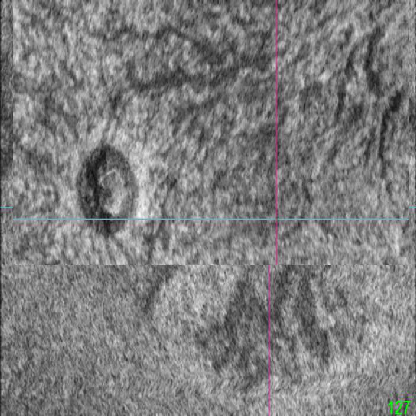

In [26]:
TF.to_pil_image(data[0])

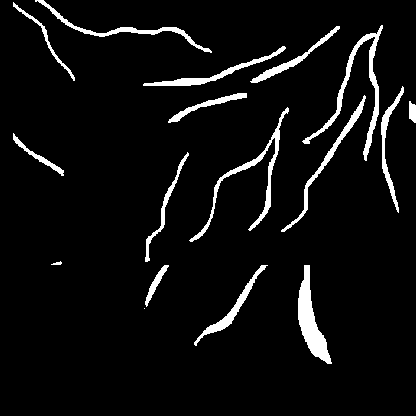

In [22]:
TF.to_pil_image(labels[0])

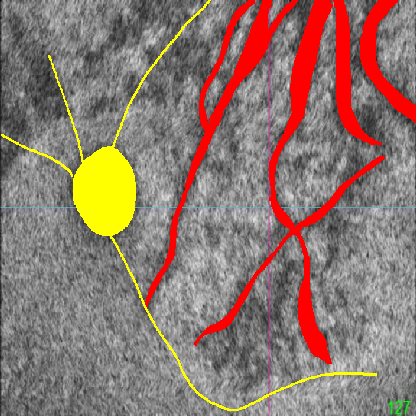

In [23]:
TF.to_pil_image(masks[1][0].permute(2, 0, 1))

In [18]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
def calc_metric(labels, preds):
    accuracy = np.mean(np.equal(labels,preds))
    right = np.sum(labels *preds == 1)
    precision = right / np.sum(preds)
    recall = right / np.sum(labels)
    f1 = 2 * precision*recall/(precision+recall)

    
    y_pred = preds
    y_true = labels
    """ Ground truth """
    #y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    #y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)
    print('jaccard, f1, recall, precision, acc')
    print(score_jaccard, score_f1, score_recall, score_precision, score_acc)
    return score_jaccard, score_f1, score_recall, score_precision, score_acc

# Train

Using 2 GPUs.
cutmix_b32_e500_js_220921_00:30
../model/vessel_PFNet_cutmix_b32_e500_js220921_00:30.pt
Training 500 epochs.


100%|██████████| 30/30 [01:27<00:00,  2.93s/it, Epoch=1, Loss=9.306084, Mean Loss=10.163532, lr=0.002000] 


Testing...


100%|██████████| 171/171 [00:54<00:00,  3.16it/s]


jaccard, f1, recall, precision, acc
0.07701693406603023 0.14301898443745073 0.09278821509993036 0.3118250180107677 0.9251535249922143
Model Saved


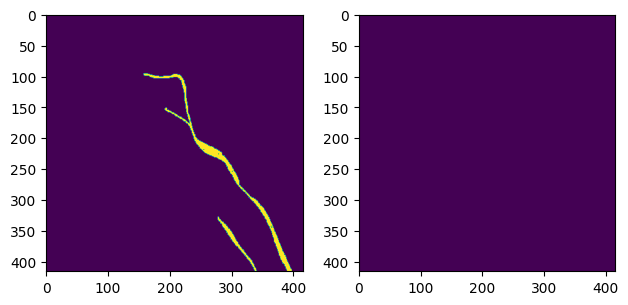

100%|██████████| 30/30 [01:18<00:00,  2.63s/it, Epoch=11, Loss=6.137147, Mean Loss=7.193737, lr=0.002000]


Testing...


100%|██████████| 171/171 [00:53<00:00,  3.17it/s]


jaccard, f1, recall, precision, acc
0.24243707136275466 0.3902605241758281 0.4723654596234531 0.33247147821404116 0.9006497778361708
Model Saved


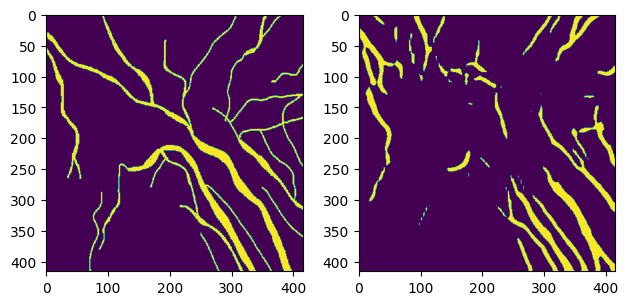

100%|██████████| 30/30 [01:16<00:00,  2.54s/it, Epoch=21, Loss=6.141107, Mean Loss=6.633883, lr=0.002000]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.30it/s]


jaccard, f1, recall, precision, acc
0.14885165179716672 0.25913119690312625 0.20974256427609286 0.3389429941845371 0.9192747870276653


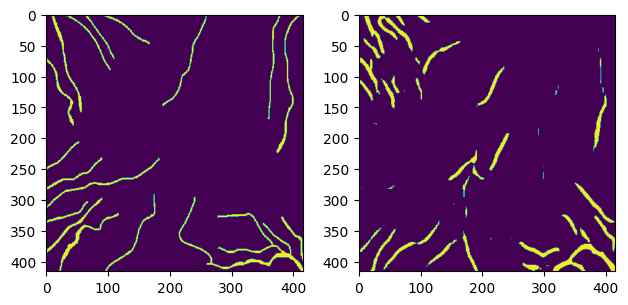

100%|██████████| 30/30 [01:15<00:00,  2.52s/it, Epoch=31, Loss=5.064290, Mean Loss=6.033184, lr=0.002000]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.36it/s]


jaccard, f1, recall, precision, acc
0.1289503730893433 0.22844294339789967 0.15518990760790166 0.4326750398573394 0.9294406137539362
Model Saved


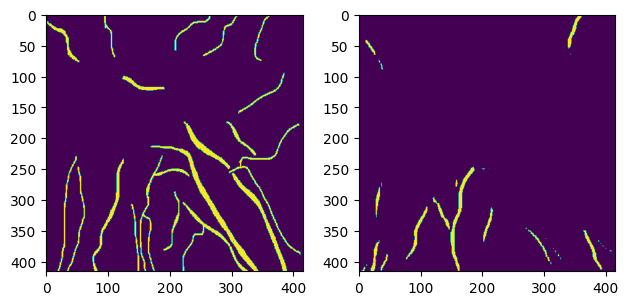

100%|██████████| 30/30 [01:15<00:00,  2.52s/it, Epoch=41, Loss=5.375913, Mean Loss=6.112609, lr=0.002000]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.36it/s]


jaccard, f1, recall, precision, acc
0.10962115212390124 0.19758302536695127 0.14023486861625725 0.33428795737581707 0.9233331697787985


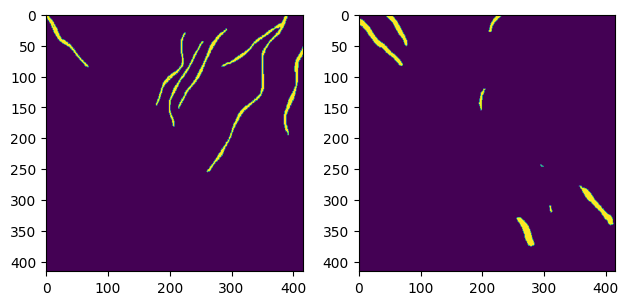

100%|██████████| 30/30 [01:15<00:00,  2.50s/it, Epoch=51, Loss=5.006407, Mean Loss=5.692781, lr=0.002000]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.37it/s]


jaccard, f1, recall, precision, acc
0.16800497397512323 0.2876785248667982 0.22017765509928774 0.41486584152234207 0.926608991390273


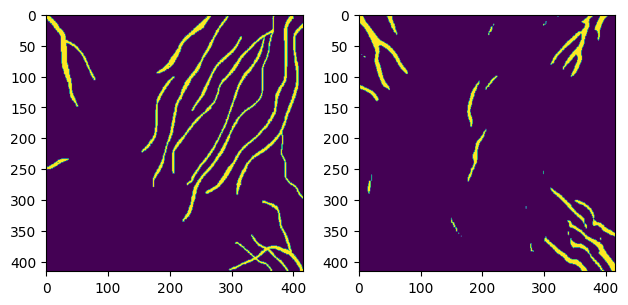

100%|██████████| 30/30 [01:19<00:00,  2.64s/it, Epoch=61, Loss=4.677344, Mean Loss=5.817481, lr=0.002000]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.34it/s]


jaccard, f1, recall, precision, acc
0.09391330420628802 0.17170154864224602 0.11888020957538192 0.3089958385585153 0.9227989479523513


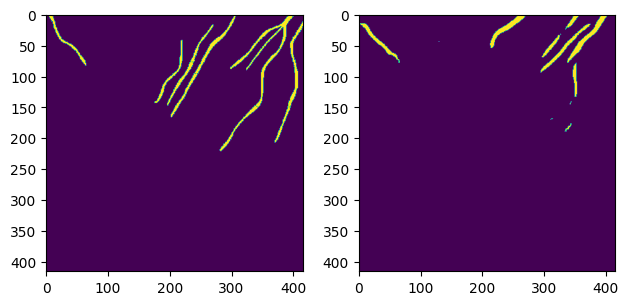

100%|██████████| 30/30 [01:15<00:00,  2.52s/it, Epoch=71, Loss=6.087520, Mean Loss=5.125353, lr=0.002000]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.31it/s]


jaccard, f1, recall, precision, acc
0.07834263560504959 0.14530193468811917 0.09622674947799444 0.2965316863820189 0.9238029497668604


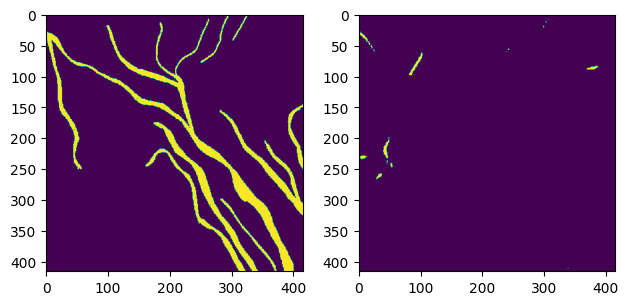

100%|██████████| 30/30 [01:15<00:00,  2.52s/it, Epoch=81, Loss=4.686738, Mean Loss=4.835431, lr=0.001000]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.30it/s]


jaccard, f1, recall, precision, acc
0.06662846031653989 0.12493283799452863 0.07903106529299335 0.29803157581850437 0.9254815802449912


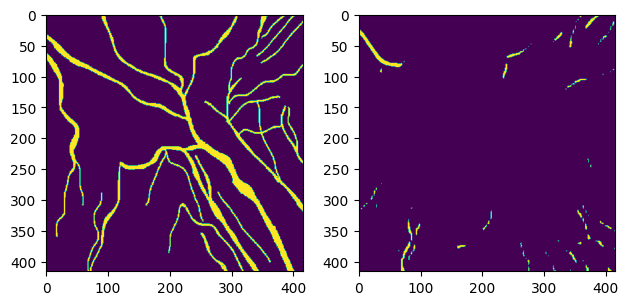

100%|██████████| 30/30 [01:18<00:00,  2.61s/it, Epoch=91, Loss=4.501848, Mean Loss=4.548331, lr=0.001000]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.37it/s]


jaccard, f1, recall, precision, acc
0.06552514956612494 0.12299127729234055 0.08144692562694639 0.2510429884559438 0.9218182627967231


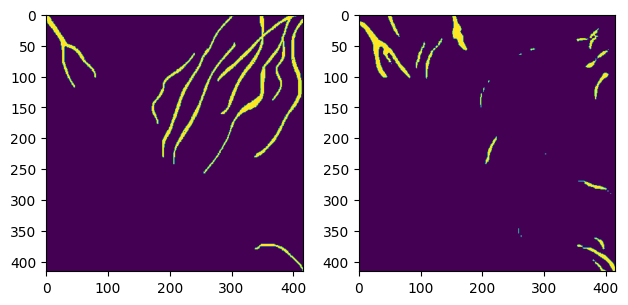

100%|██████████| 30/30 [01:17<00:00,  2.58s/it, Epoch=101, Loss=4.272662, Mean Loss=4.576693, lr=0.001000]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.34it/s]


jaccard, f1, recall, precision, acc
0.0458779784786543 0.08773103444703734 0.05527359919511486 0.21253397578453176 0.9226271818985952


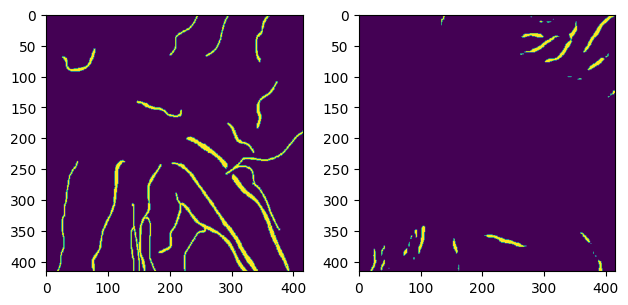

100%|██████████| 30/30 [01:16<00:00,  2.55s/it, Epoch=111, Loss=4.237363, Mean Loss=4.308287, lr=0.000500]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


jaccard, f1, recall, precision, acc
0.05089769269210299 0.0968651716452388 0.06289420268827219 0.21063542878664576 0.9210600996682411


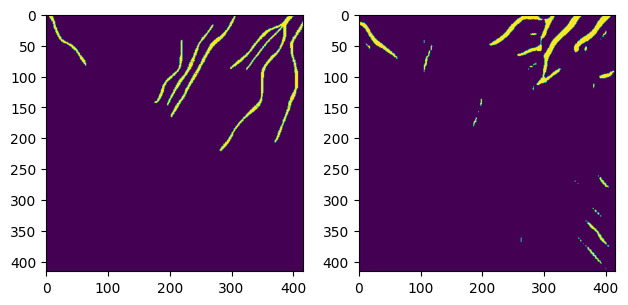

100%|██████████| 30/30 [01:16<00:00,  2.57s/it, Epoch=121, Loss=3.495607, Mean Loss=4.137760, lr=0.000500]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.29it/s]


jaccard, f1, recall, precision, acc
0.05169266758016415 0.09830375198698232 0.0655887002801936 0.19613324365549298 0.9190120860042735


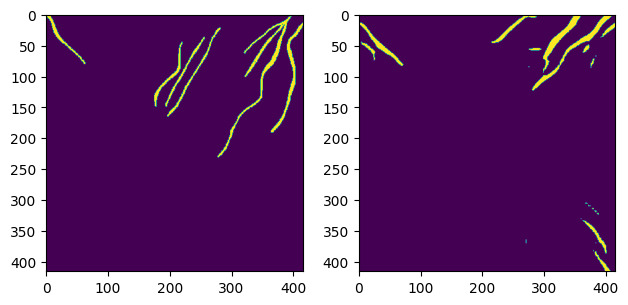

100%|██████████| 30/30 [01:16<00:00,  2.54s/it, Epoch=131, Loss=4.255550, Mean Loss=4.341713, lr=0.000500]


Testing...


100%|██████████| 171/171 [00:52<00:00,  3.23it/s]


jaccard, f1, recall, precision, acc
0.04429824058685312 0.08483829401447485 0.0582095824106089 0.15637319493915358 0.9154718399641856


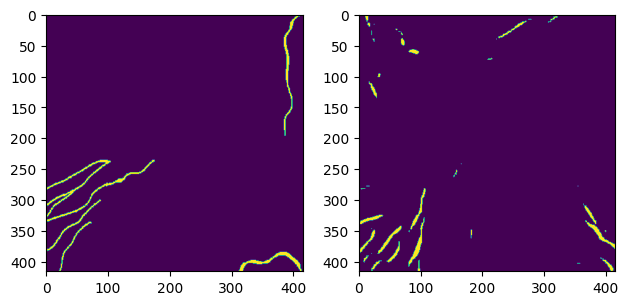

100%|██████████| 30/30 [01:15<00:00,  2.53s/it, Epoch=141, Loss=4.089028, Mean Loss=4.076063, lr=0.000250]


Testing...


100%|██████████| 171/171 [00:52<00:00,  3.27it/s]


jaccard, f1, recall, precision, acc
0.040791793397945655 0.07838607809304461 0.051704532047552085 0.16196769987843027 0.9181648802726738


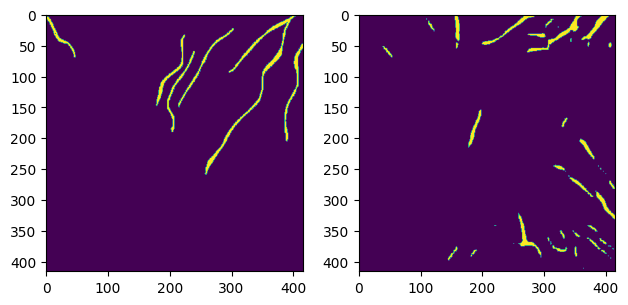

100%|██████████| 30/30 [01:16<00:00,  2.54s/it, Epoch=151, Loss=3.993314, Mean Loss=4.044791, lr=0.000250]


Testing...


100%|██████████| 171/171 [00:52<00:00,  3.23it/s]


jaccard, f1, recall, precision, acc
0.04115277697648598 0.07905233100562609 0.05264286184060242 0.15863525510296708 0.9174416921325133


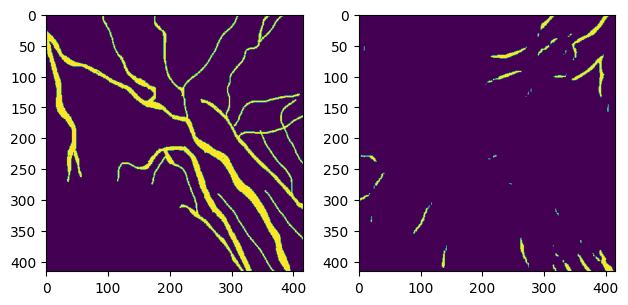

100%|██████████| 30/30 [01:17<00:00,  2.60s/it, Epoch=161, Loss=3.600578, Mean Loss=4.048842, lr=0.000125]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.34it/s]


jaccard, f1, recall, precision, acc
0.0394373725671358 0.07588215241816043 0.049116970916796905 0.16674734197581786 0.9194769323224852


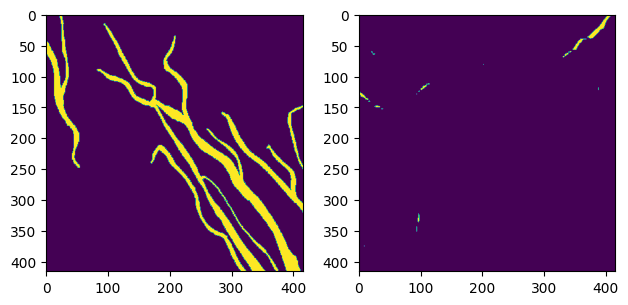

100%|██████████| 30/30 [01:18<00:00,  2.60s/it, Epoch=171, Loss=4.013744, Mean Loss=3.800047, lr=0.000125]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.41it/s]


jaccard, f1, recall, precision, acc
0.03918469947244243 0.07541431180104004 0.04780210428865414 0.1785528097304474 0.921106462647929


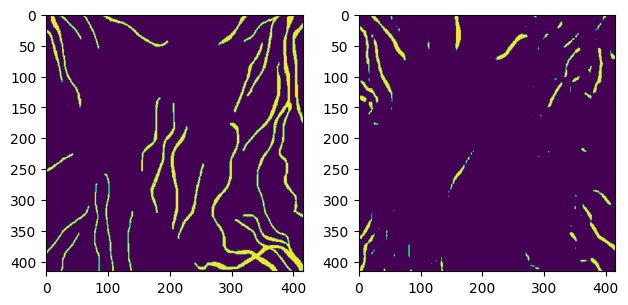

100%|██████████| 30/30 [01:16<00:00,  2.55s/it, Epoch=181, Loss=3.213101, Mean Loss=3.765437, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:48<00:00,  3.51it/s]


jaccard, f1, recall, precision, acc
0.04333108465762407 0.0830629611152503 0.05420825097636001 0.17759641037281199 0.9194438834929409


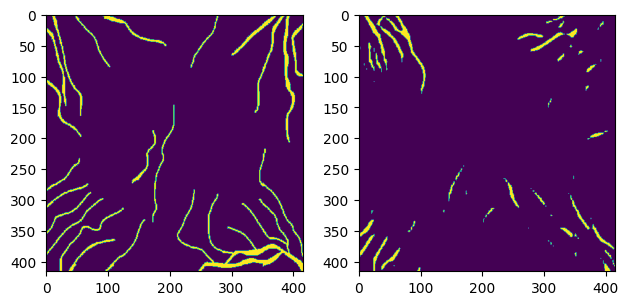

100%|██████████| 30/30 [01:18<00:00,  2.62s/it, Epoch=191, Loss=3.732080, Mean Loss=3.709755, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


jaccard, f1, recall, precision, acc
0.04123475487695232 0.07920356996117602 0.05429359932564763 0.14634839481479778 0.9150294317061144


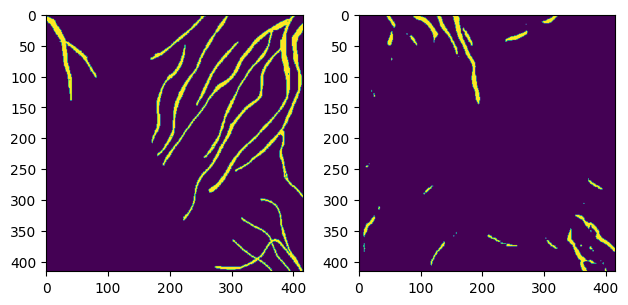

100%|██████████| 30/30 [01:16<00:00,  2.55s/it, Epoch=201, Loss=4.720157, Mean Loss=3.958160, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.39it/s]


jaccard, f1, recall, precision, acc
0.04221596136154554 0.08101192636964573 0.055292175012312754 0.15146968213275827 0.9155643969622651


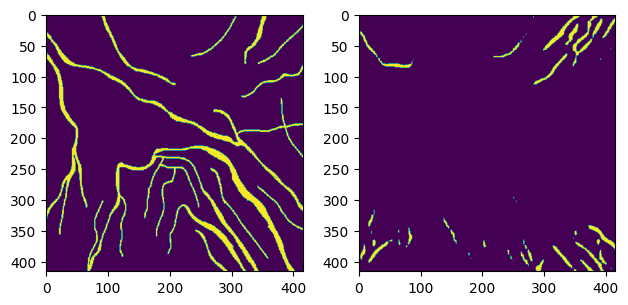

100%|██████████| 30/30 [01:16<00:00,  2.53s/it, Epoch=211, Loss=5.256305, Mean Loss=3.894397, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:52<00:00,  3.28it/s]


jaccard, f1, recall, precision, acc
0.02892193118926777 0.05621793123962026 0.03529806906890474 0.1380133443522061 0.9202283032068583


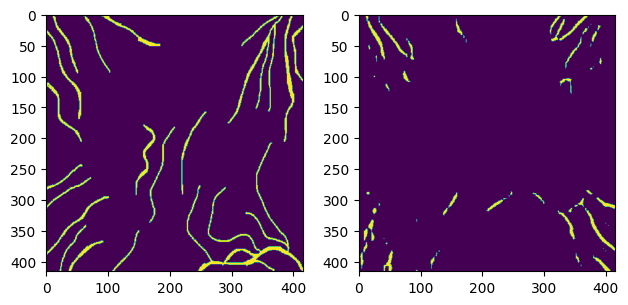

100%|██████████| 30/30 [01:16<00:00,  2.55s/it, Epoch=221, Loss=3.098921, Mean Loss=3.812473, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.31it/s]


jaccard, f1, recall, precision, acc
0.06259350216847565 0.11781269514774685 0.08316092130028713 0.20197040731099147 0.9161720155757984


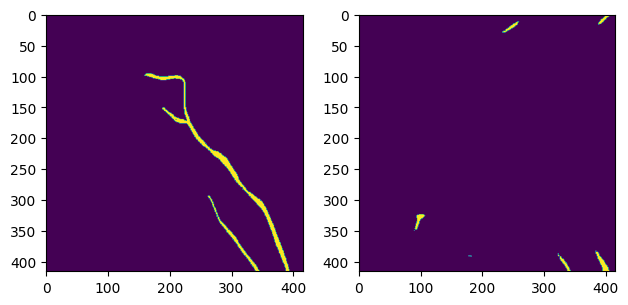

100%|██████████| 30/30 [01:16<00:00,  2.56s/it, Epoch=231, Loss=3.262676, Mean Loss=3.686687, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:49<00:00,  3.44it/s]


jaccard, f1, recall, precision, acc
0.04093292090441097 0.07864660648612504 0.051667882462269756 0.16458655851383683 0.9185168266527388


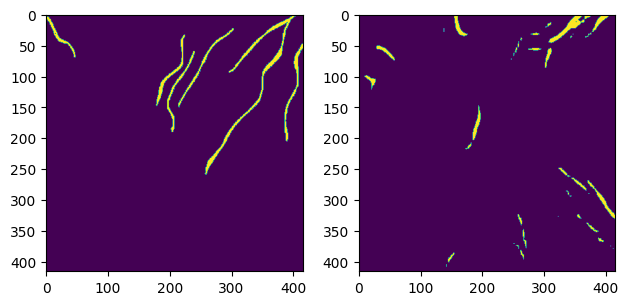

100%|██████████| 30/30 [01:17<00:00,  2.59s/it, Epoch=241, Loss=3.331296, Mean Loss=3.753953, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:48<00:00,  3.53it/s]


jaccard, f1, recall, precision, acc
0.034563030772835124 0.06681667475980847 0.044143170349782636 0.13737986722310674 0.9170060085340324


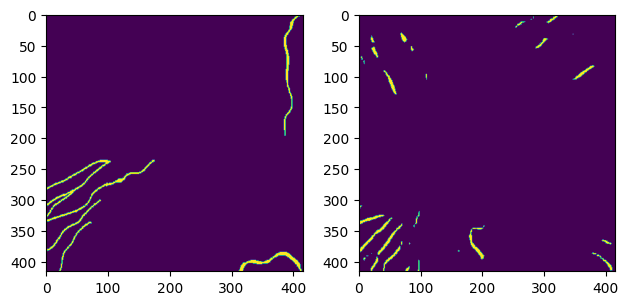

100%|██████████| 30/30 [01:16<00:00,  2.55s/it, Epoch=251, Loss=3.004236, Mean Loss=3.625778, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.41it/s]


jaccard, f1, recall, precision, acc
0.0317448533892081 0.06153624761960969 0.03821397031986051 0.15790980494666218 0.9215469785394823


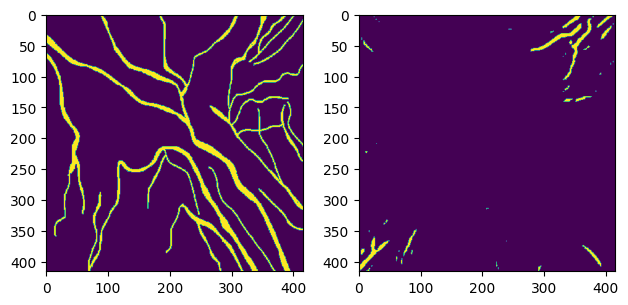

100%|██████████| 30/30 [01:21<00:00,  2.71s/it, Epoch=261, Loss=3.537871, Mean Loss=3.853292, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:48<00:00,  3.52it/s]


jaccard, f1, recall, precision, acc
0.04900302114803625 0.09342779793790681 0.06025995098996555 0.20780794714599085 0.9212852574916087


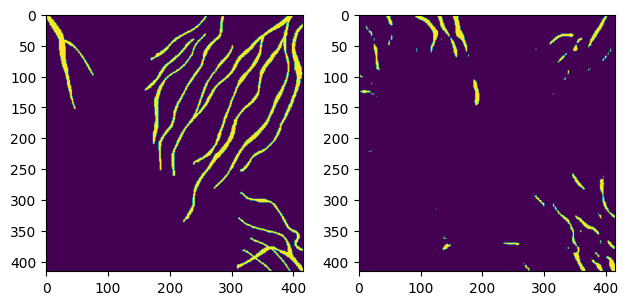

100%|██████████| 30/30 [01:18<00:00,  2.62s/it, Epoch=271, Loss=3.526154, Mean Loss=3.637211, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:48<00:00,  3.51it/s]


jaccard, f1, recall, precision, acc
0.04200024511052256 0.08061465495349801 0.05299279007268165 0.16838154124951346 0.918641790427437


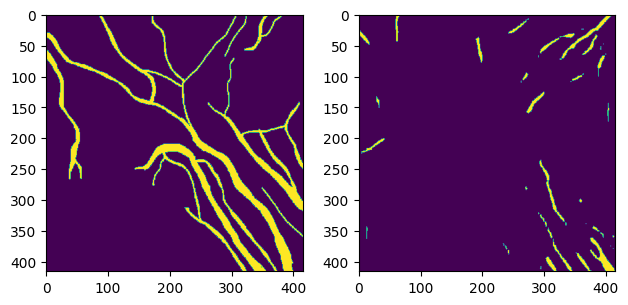

100%|██████████| 30/30 [01:18<00:00,  2.62s/it, Epoch=281, Loss=3.454701, Mean Loss=3.979567, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:48<00:00,  3.55it/s]


jaccard, f1, recall, precision, acc
0.025636010147710837 0.04999046424670439 0.030399073819795494 0.14060957910014513 0.9222317786731374


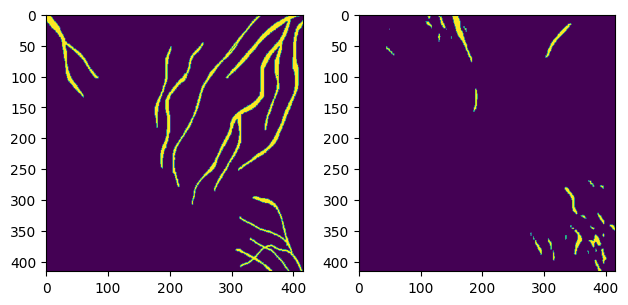

100%|██████████| 30/30 [01:18<00:00,  2.60s/it, Epoch=291, Loss=3.339434, Mean Loss=3.647718, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:48<00:00,  3.54it/s]


jaccard, f1, recall, precision, acc
0.03759519897794424 0.07246602338749525 0.04804459401045367 0.1473807903061366 0.9172170411930344


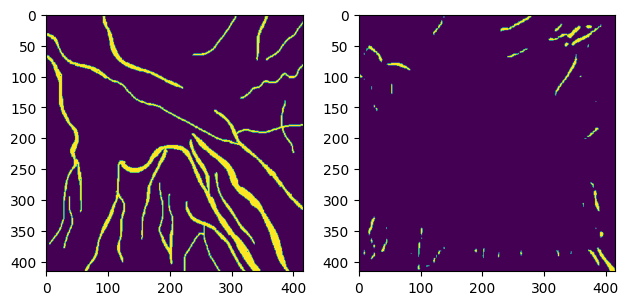

100%|██████████| 30/30 [01:16<00:00,  2.56s/it, Epoch=301, Loss=3.422950, Mean Loss=3.792766, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:47<00:00,  3.58it/s]


jaccard, f1, recall, precision, acc
0.04577427539721511 0.0875414063514399 0.058219623392878034 0.17636707907804386 0.918309781480328


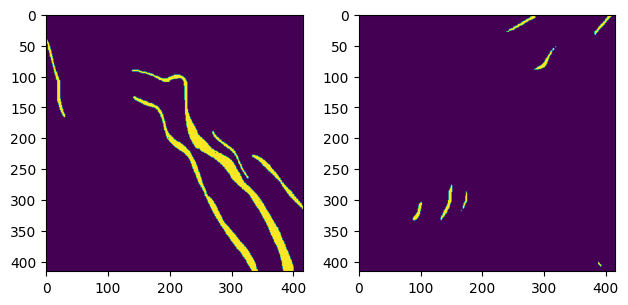

100%|██████████| 30/30 [01:18<00:00,  2.63s/it, Epoch=311, Loss=3.652718, Mean Loss=3.584069, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:46<00:00,  3.68it/s]


jaccard, f1, recall, precision, acc
0.043790712608862754 0.08390707462688901 0.053885935445520894 0.1894594513492093 0.9208014199236998


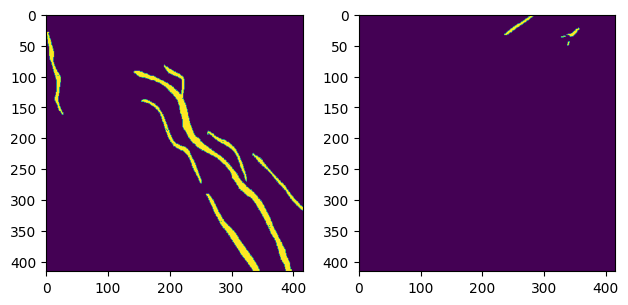

100%|██████████| 30/30 [01:17<00:00,  2.58s/it, Epoch=321, Loss=2.968689, Mean Loss=3.607424, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:46<00:00,  3.70it/s]


jaccard, f1, recall, precision, acc
0.04041952419796785 0.07769851152904152 0.05002668391038022 0.17387715786883787 0.9200602205093602


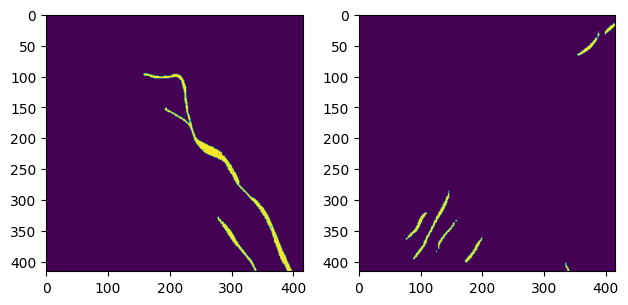

100%|██████████| 30/30 [01:09<00:00,  2.33s/it, Epoch=331, Loss=3.616665, Mean Loss=3.630681, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:39<00:00,  4.29it/s]


jaccard, f1, recall, precision, acc
0.0370463831976163 0.07144595226953673 0.04599171518552974 0.1599963672119924 0.9195344129554656


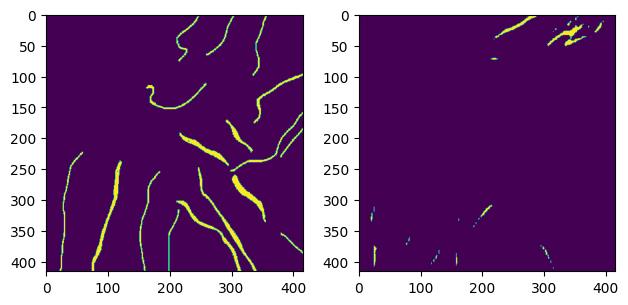

100%|██████████| 30/30 [01:14<00:00,  2.48s/it, Epoch=341, Loss=3.304600, Mean Loss=3.572446, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:54<00:00,  3.13it/s]


jaccard, f1, recall, precision, acc
0.040923892880096666 0.07862994241945154 0.05172360991386343 0.16387875278764877 0.918410178282553


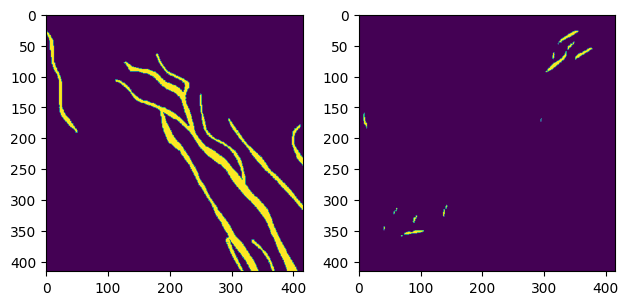

100%|██████████| 30/30 [01:16<00:00,  2.54s/it, Epoch=351, Loss=4.027627, Mean Loss=3.665411, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.31it/s]


jaccard, f1, recall, precision, acc
0.04864864864864865 0.09278350515463918 0.06766366926610963 0.14756715386729413 0.9109371215266965


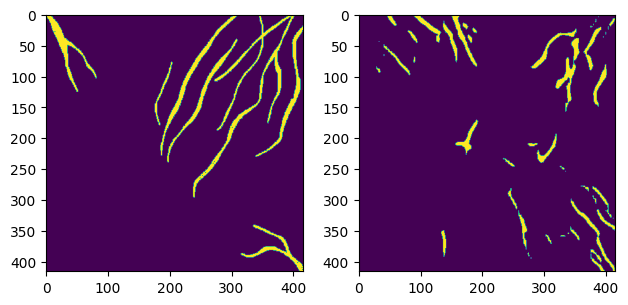

100%|██████████| 30/30 [01:16<00:00,  2.55s/it, Epoch=361, Loss=3.475052, Mean Loss=3.640184, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:53<00:00,  3.22it/s]


jaccard, f1, recall, precision, acc
0.05900878090299277 0.1114415328127446 0.07880263294637062 0.19023344992497898 0.915417468219056


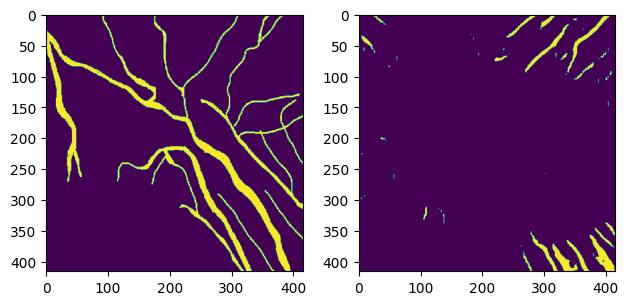

100%|██████████| 30/30 [01:16<00:00,  2.56s/it, Epoch=371, Loss=3.273443, Mean Loss=3.627727, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:53<00:00,  3.20it/s]


jaccard, f1, recall, precision, acc
0.036657435400241724 0.07072237008764366 0.04494996327510735 0.16576501518181144 0.9204904973463615


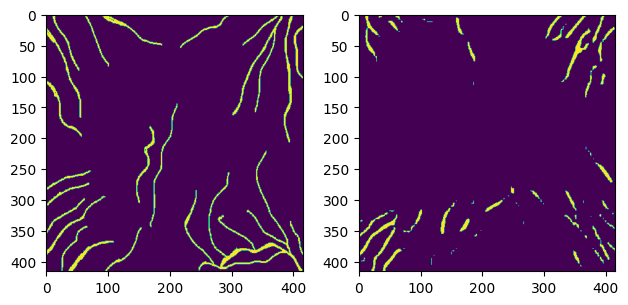

100%|██████████| 30/30 [01:16<00:00,  2.56s/it, Epoch=381, Loss=3.023644, Mean Loss=3.486444, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:54<00:00,  3.14it/s]


jaccard, f1, recall, precision, acc
0.05053235296717177 0.09620332553194744 0.06314874158879466 0.20187037681978162 0.9201368613533341


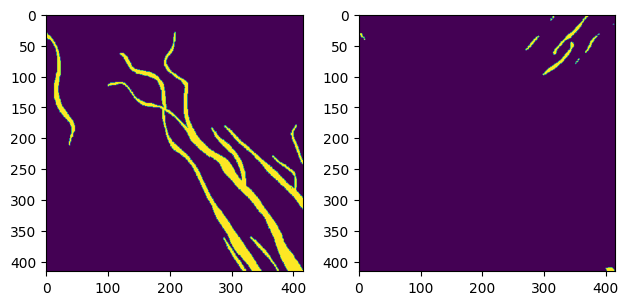

100%|██████████| 30/30 [01:14<00:00,  2.49s/it, Epoch=391, Loss=2.878679, Mean Loss=3.383183, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:55<00:00,  3.09it/s]


jaccard, f1, recall, precision, acc
0.04455810528137793 0.08531474708029782 0.054798158684671486 0.19253660257541014 0.9209112785585142


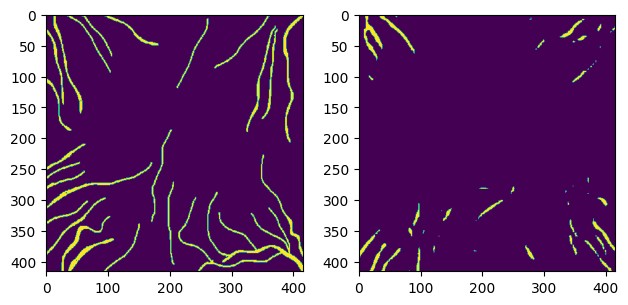

100%|██████████| 30/30 [01:15<00:00,  2.50s/it, Epoch=401, Loss=3.388811, Mean Loss=3.577549, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:54<00:00,  3.13it/s]


jaccard, f1, recall, precision, acc
0.04180136145106244 0.08024823732777586 0.0510071858289609 0.18805529230586981 0.9213013088147514


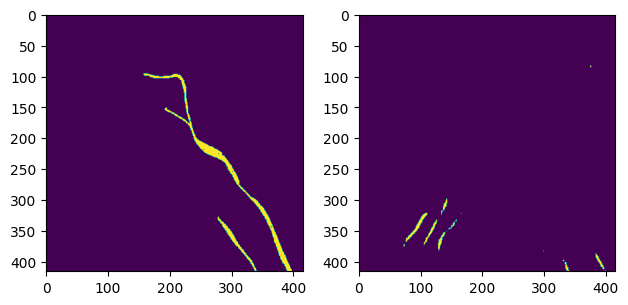

100%|██████████| 30/30 [01:17<00:00,  2.59s/it, Epoch=411, Loss=3.140195, Mean Loss=3.438099, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:55<00:00,  3.10it/s]


jaccard, f1, recall, precision, acc
0.027342570968025053 0.05322970495082514 0.03206336663090403 0.15662284219019382 0.9232283799828713


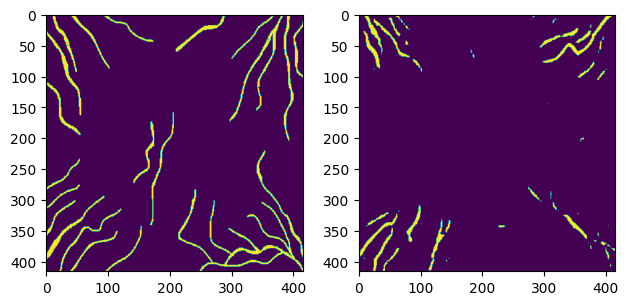

100%|██████████| 30/30 [01:14<00:00,  2.49s/it, Epoch=421, Loss=3.619046, Mean Loss=3.655823, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:53<00:00,  3.20it/s]


jaccard, f1, recall, precision, acc
0.03297082664010181 0.06383689798354625 0.03898210546344907 0.17614791288566242 0.9230433673634901


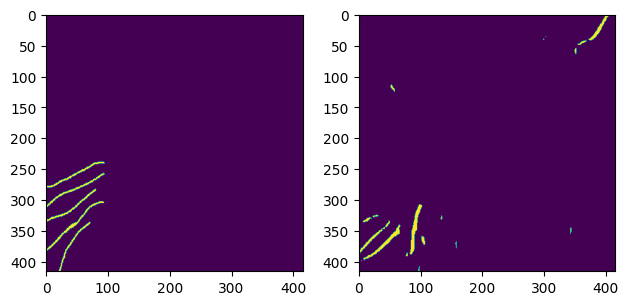

100%|██████████| 30/30 [01:14<00:00,  2.47s/it, Epoch=431, Loss=4.077264, Mean Loss=3.435311, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:52<00:00,  3.27it/s]


jaccard, f1, recall, precision, acc
0.03813480302729645 0.07346792134526627 0.04486461492581973 0.2026964803763459 0.9238328559162947


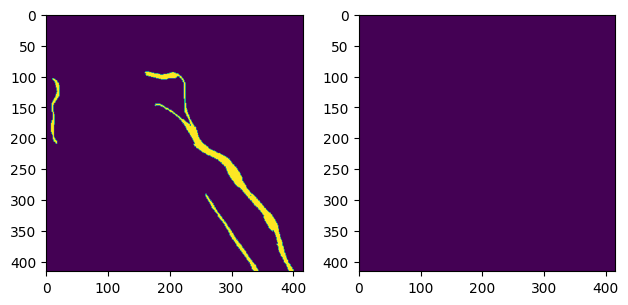

100%|██████████| 30/30 [01:14<00:00,  2.49s/it, Epoch=441, Loss=3.808539, Mean Loss=3.492805, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:52<00:00,  3.23it/s]


jaccard, f1, recall, precision, acc
0.035681101979870934 0.068903645942097 0.042241910357122596 0.1868157243247444 0.9231582948371916


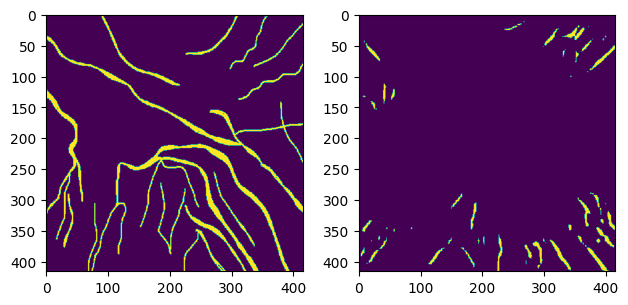

100%|██████████| 30/30 [01:17<00:00,  2.57s/it, Epoch=451, Loss=3.265946, Mean Loss=3.400610, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:52<00:00,  3.27it/s]


jaccard, f1, recall, precision, acc
0.03548447582390575 0.0685369537687598 0.04341971757729172 0.16259299018068812 0.920561900390152


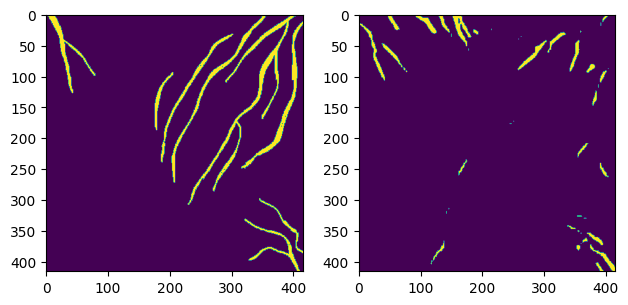

100%|██████████| 30/30 [01:16<00:00,  2.54s/it, Epoch=461, Loss=3.413411, Mean Loss=3.553912, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:53<00:00,  3.17it/s]


jaccard, f1, recall, precision, acc
0.030175701416323357 0.058583601563959815 0.03761954416952793 0.13232206397838545 0.9186195213285927


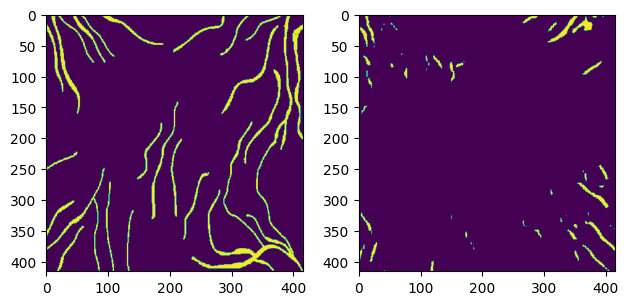

100%|██████████| 30/30 [01:16<00:00,  2.54s/it, Epoch=471, Loss=3.831068, Mean Loss=3.415490, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:54<00:00,  3.15it/s]


jaccard, f1, recall, precision, acc
0.04865165857926975 0.09278897941225556 0.06294591374695821 0.17644062167532606 0.9171522952243157


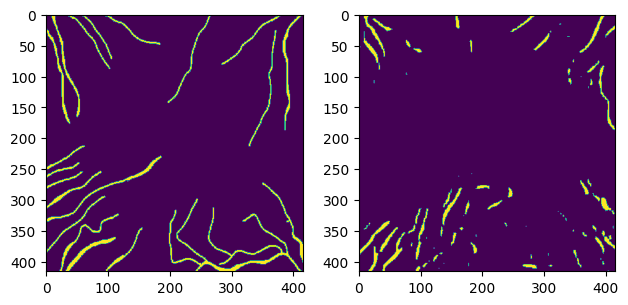

100%|██████████| 30/30 [01:14<00:00,  2.49s/it, Epoch=481, Loss=3.375375, Mean Loss=3.511422, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:54<00:00,  3.16it/s]


jaccard, f1, recall, precision, acc
0.03673489878136021 0.0708665230128562 0.048493425917883845 0.1315665092534199 0.9144104251012146


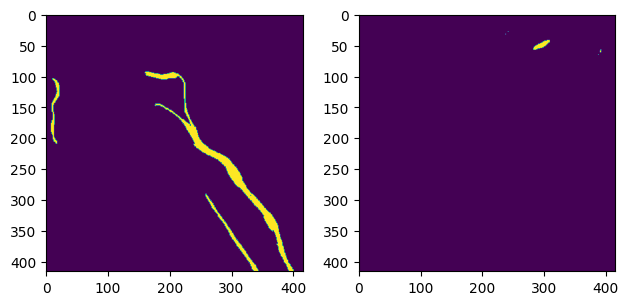

100%|██████████| 30/30 [01:22<00:00,  2.76s/it, Epoch=491, Loss=3.712243, Mean Loss=3.483060, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:53<00:00,  3.17it/s]


jaccard, f1, recall, precision, acc
0.03947745660428375 0.07595634970910643 0.05101772886034349 0.1485909891151131 0.9164492134784076


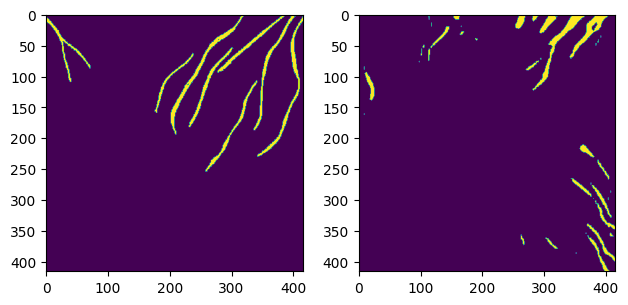

100%|██████████| 30/30 [01:17<00:00,  2.57s/it, Epoch=500, Loss=3.937645, Mean Loss=3.406649, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:55<00:00,  3.06it/s]


jaccard, f1, recall, precision, acc
0.031012954939732724 0.06016016538132747 0.03792830437430372 0.14536879536340755 0.9202355685425966


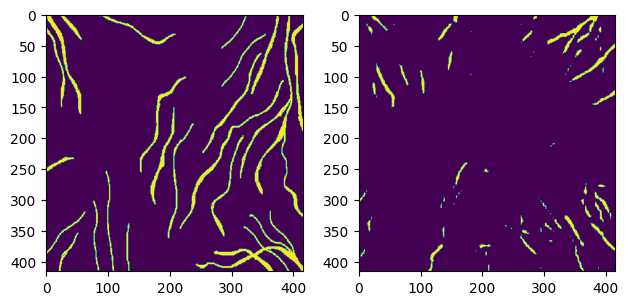

In [19]:
from tensorboardX import SummaryWriter
import datetime 

exp = 'cutmix'

num_epochs = args['epoch_num']
batch_size = args['train_batch_size']
scaler = torch.cuda.amp.GradScaler()
now = datetime.datetime.now()
log_name = f'{exp}_b{batch_size}_e{num_epochs}_js_'+now.strftime("%y%m%d_%H:%M")
writer = SummaryWriter(log_dir='./ckpt/PFNet/log/'+ log_name)
save_path = f'../model/vessel_PFNet_{exp}_b{batch_size}_e{num_epochs}_js'+ now.strftime("%y%m%d_%H:%M") + '.pt'

if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    net = nn.DataParallel(net)

# net.float()
net = net.to(device)
net.train()
train_loss_list = []
test_acc_list = []
test_recall_list = []

print(log_name)
print(save_path)
print(f'Training {num_epochs} epochs.')
if args['amp'] == True:
    print("Using mixed precision.")

curr_iter = 1

for epoch in range(num_epochs):

    net.train()

    loss_1_running, loss_2_running, loss_3_running, loss_4_running, loss_running = 0, 0, 0, 0, 0
    tqdm_dataset = tqdm(train_loader)
    for batch_idx, batch in enumerate(tqdm_dataset):
        if args['poly_train']:
            base_lr = args['lr'] * (1 - float(curr_iter) / float(num_epochs)) ** args['lr_decay']
            optimizer.param_groups[0]['lr'] = 2 * base_lr
            optimizer.param_groups[1]['lr'] = 1 * base_lr

        inputs, label_list, _ = batch

        labels = label_list[0]
        labels = labels.unsqueeze(1)
        inputs, labels = inputs.float().to(device), labels.float().to(device)
        optimizer.zero_grad()

        # mixed precision
        if args['amp'] == True:
            with torch.cuda.amp.autocast():
                alpha = 1.0
                target_a = labels
                inputs, target_b, lam, (bbx1, bby1, bbx2, bby2) = cutmix(inputs, labels, alpha)
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
                
                predict_1, predict_2, predict_3, predict_4 = net(inputs)

                loss_1 = bce_iou_loss(predict_1, target_a) * lam + bce_iou_loss(predict_1, target_b) * (1. - lam)
                loss_2 = structure_loss(predict_2, target_a)* lam + structure_loss(predict_2, target_b) * (1. - lam)
                loss_3 = structure_loss(predict_3, target_a)* lam + structure_loss(predict_3, target_b) * (1. - lam)
                loss_4 = structure_loss(predict_4, target_a)* lam + structure_loss(predict_4, target_b) * (1. - lam)
                loss = 1 * loss_1 + 1 * loss_2 + 2 * loss_3 + 4 * loss_4

            scaler.scale(loss).backward()
            # nn.utils.clip_grad_norm_(net.parameters(), max_norm=20)
            scaler.step(optimizer)
            scaler.update()

        else:
            alpha = 1.0
            target_a = labels
            inputs, target_b, lam, (bbx1, bby1, bbx2, bby2) = cutmix(inputs, labels, alpha)
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
            
            predict_1, predict_2, predict_3, predict_4 = net(inputs)

            loss_1 = bce_iou_loss(predict_1, target_a) * lam + bce_iou_loss(predict_1, target_b) * (1. - lam)
            loss_2 = structure_loss(predict_2, target_a)* lam + structure_loss(predict_2, target_b) * (1. - lam)
            loss_3 = structure_loss(predict_3, target_a)* lam + structure_loss(predict_3, target_b) * (1. - lam)
            loss_4 = structure_loss(predict_4, target_a)* lam + structure_loss(predict_4, target_b) * (1. - lam)
            loss = 1 * loss_1 + 1 * loss_2 + 2 * loss_3 + 4 * loss_4
            
            loss.backward()
            # nn.utils.clip_grad_norm_(net.parameters(), max_norm=20)
            optimizer.step()
        
        loss_1_running += loss_1.item()
        loss_2_running += loss_2.item()
        loss_3_running += loss_3.item()
        loss_4_running += loss_4.item()
        loss_running += loss.item()
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(loss.item()),
            'Mean Loss' : '{:06f}'.format(loss_running/(batch_idx+1)),
            'lr' : '{:06f}'.format(optimizer.param_groups[0]["lr"])
        })

        curr_iter += 1
        
    epoch_loss = loss_running / len(train_loader)
    epoch_loss_1 = loss_1_running / len(train_loader)
    epoch_loss_2 = loss_2_running / len(train_loader)
    epoch_loss_3 = loss_3_running / len(train_loader)
    epoch_loss_4 = loss_4_running / len(train_loader)

    scheduler.step(epoch_loss)

    writer.add_scalar('loss/Train', epoch_loss, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    train_loss_list.append(epoch_loss)
    
## EVAL
    if epoch % 10 == 0 or epoch == args['epoch_num']-1 :
        print("Testing...")

        inputs=[]
        preds=[]
        labels=[]
        label_os = []
        urls_list = []

        net.eval()
        net.to(device)
        tqdm_loader = tqdm(test_loader)
        with torch.no_grad():
            for idx, dd in enumerate(tqdm_loader):
                data, target, urls = dd 
                
                data = data.float().to(device)
                label = target[0].float()
                label_o = target[1].float()
                _, _, _, pred = net(data)    

                inputs.append(data.cpu().detach().numpy())
                labels.append(label.numpy())
                label_os.append(label_o)
                preds.append(pred.cpu().detach().numpy())
                urls_list.append(urls)

            inputs = np.array(inputs).squeeze(1)
            preds = np.array(preds).squeeze(1)
            labels = np.array(labels)
            preds = np.where(preds > 0.5 , 1 , 0)
            labels = np.where(labels > 0.5 , 1 , 0)
            
            score_jaccard, score_f1, score_recall, score_precision, score_acc = calc_metric(labels=labels, preds=preds)
            test_acc_list.append(score_acc)
            test_recall_list.append(score_recall)
            writer.add_scalar('Accuracy/Test', score_acc, epoch)
            writer.add_scalar('F1/Test', score_f1, epoch)
            writer.add_scalar('Recall/Test', score_recall, epoch)
            writer.add_scalar('Precision/Test', score_precision, epoch)
            writer.add_scalar('Jaccard/Test', score_jaccard, epoch)

            if np.max(test_acc_list) == test_acc_list[-1] or np.max(test_recall_list) == test_recall_list[-1]:
                torch.save(net.state_dict(), save_path)
                print("Model Saved")

            randnum = np.random.randint(0, 171)
            plt.subplot(1, 2, 1)  
            plt.imshow(labels[randnum][0])
            plt.subplot(1, 2, 2)  
            plt.imshow(preds[randnum][0])
            plt.tight_layout()
            plt.show()

# evaluation

In [20]:
# save_model = torch.load('../model/vessel_PFNet_baseline_e200_JS_220918_19:44.pt')
save_model = torch.load(save_path)
net = PFNet(backbone_path)
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
net.load_state_dict(save_model)


inputs=[]
preds=[]
labels=[]
label_os = []
urls_list = []

net.eval()
net.to(device)
tqdm_loader = tqdm(test_loader)
with torch.no_grad():
    for idx, dd in enumerate(tqdm_loader):
        data, target, urls = dd 
        
        data = data.float().to(device)
        label = target[0].float()
        label_o = target[1].float()
        _, _, _, pred = net(data)    

        inputs.append(data.cpu().detach().numpy())
        labels.append(label.numpy())
        label_os.append(label_o)
        preds.append(pred.cpu().detach().numpy())
        urls_list.append(urls)
        # if idx == 0:


inputs = np.array(inputs).squeeze(1)
preds = np.array(preds).squeeze(1)
labels = np.array(labels)
# label_os = np.array(labels).squeeze(1)

        # else:    
        #     inputs = np.concatenate( ( inputs , data.cpu().detach().numpy()  ) , axis=0)
        #     labels = np.concatenate( ( labels , target.cpu().detach().numpy()  ) , axis=0)
        #     preds = np.concatenate( (preds , pred.cpu().detach().numpy()  ) , axis=0)
        #     urls_list = np.concatenate( (urls_list , urls ) , axis=0)
            
    #     inputs.append(data.cpu().detach().numpy())
    #     preds.append( prediction.cpu().detach().numpy())
    #     labels.append( target.cpu().detach().numpy())
     

From ./backbone/resnet/resnet50-19c8e357.pth Load resnet50 Weights Succeed!


100%|██████████| 171/171 [00:34<00:00,  4.96it/s]


In [21]:
preds = np.where(preds > 0.5 , 1 , 0)
labels = np.where(labels > 0.5 , 1 , 0)

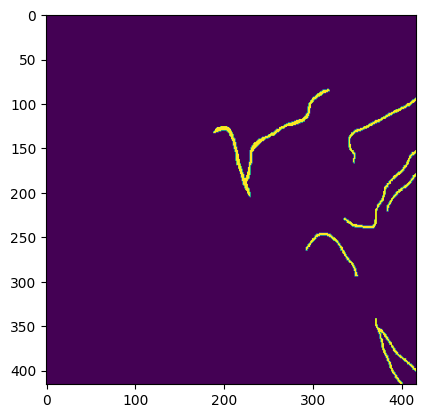

In [22]:
plt.imshow(labels[0][0])

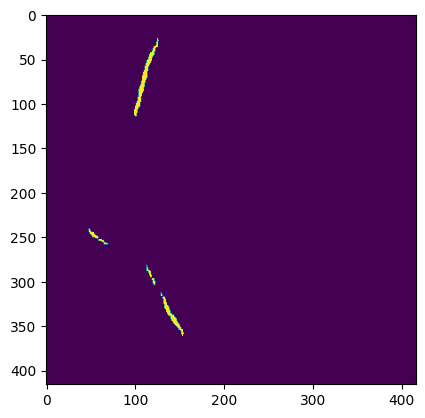

In [23]:
plt.imshow(preds[0][0])

In [24]:
accuracy = np.mean(np.equal(labels,preds))
right = np.sum(labels *preds == 1)
precision = right / np.sum(preds)
recall = right / np.sum(labels)
f1 = 2 * precision*recall/(precision+recall)

print(f1, accuracy, precision)

0.22844294339789967 0.9294406137539362 0.4326750398573394


In [25]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

y_pred = preds
y_true = labels

print(type(y_pred) , type(y_true))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [26]:
""" Ground truth """
#y_true = y_true.cpu().numpy()
y_true = y_true > 0.5
y_true = y_true.astype(np.uint8)
y_true = y_true.reshape(-1)

""" Prediction """
#y_pred = y_pred.cpu().numpy()
y_pred = y_pred > 0.5
y_pred = y_pred.astype(np.uint8)
y_pred = y_pred.reshape(-1)

score_jaccard = jaccard_score(y_true, y_pred)
score_f1 = f1_score(y_true, y_pred)
score_recall = recall_score(y_true, y_pred)
score_precision = precision_score(y_true, y_pred)
score_acc = accuracy_score(y_true, y_pred)

In [27]:
print( score_jaccard, score_f1, score_recall, score_precision , score_acc)

0.1289503730893433 0.22844294339789967 0.15518990760790166 0.4326750398573394 0.9294406137539362


In [28]:
inputs[0].astype(int)

array([[[ 70, 132, 122, ..., 101,  88,  86],
        [ 84, 140, 131, ...,  93,  87,  84],
        [100, 148, 142, ...,  87,  86,  82],
        ...,
        [ 47, 104, 155, ...,  91,  91,  40],
        [ 38,  98, 161, ...,  84,  79,  52],
        [ 22,  85, 159, ...,  74,  68,  66]],

       [[ 70, 132, 122, ..., 101,  88,  86],
        [ 84, 140, 131, ...,  93,  87,  84],
        [100, 148, 142, ...,  87,  86,  82],
        ...,
        [ 47, 104, 155, ...,  93,  83,  47],
        [ 38,  98, 161, ...,  94,  89,  52],
        [ 22,  85, 159, ...,  94,  92,  55]],

       [[ 70, 132, 122, ..., 101,  88,  86],
        [ 84, 140, 131, ...,  93,  87,  84],
        [100, 148, 142, ...,  87,  86,  82],
        ...,
        [ 47, 104, 155, ...,  92,  96,  63],
        [ 38,  98, 161, ...,  93,  90,  62],
        [ 22,  85, 159, ...,  85,  79,  61]]])

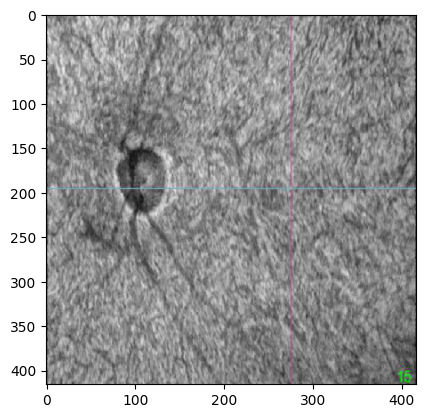

In [29]:
plt.imshow(inputs[0].astype(int).transpose(1, 2, 0))

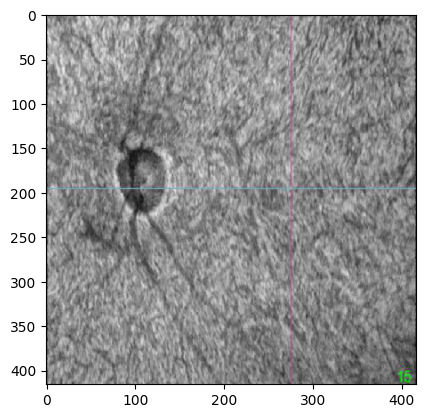

In [30]:
plt.imshow(inputs[0].astype(int).transpose(1,2,0))

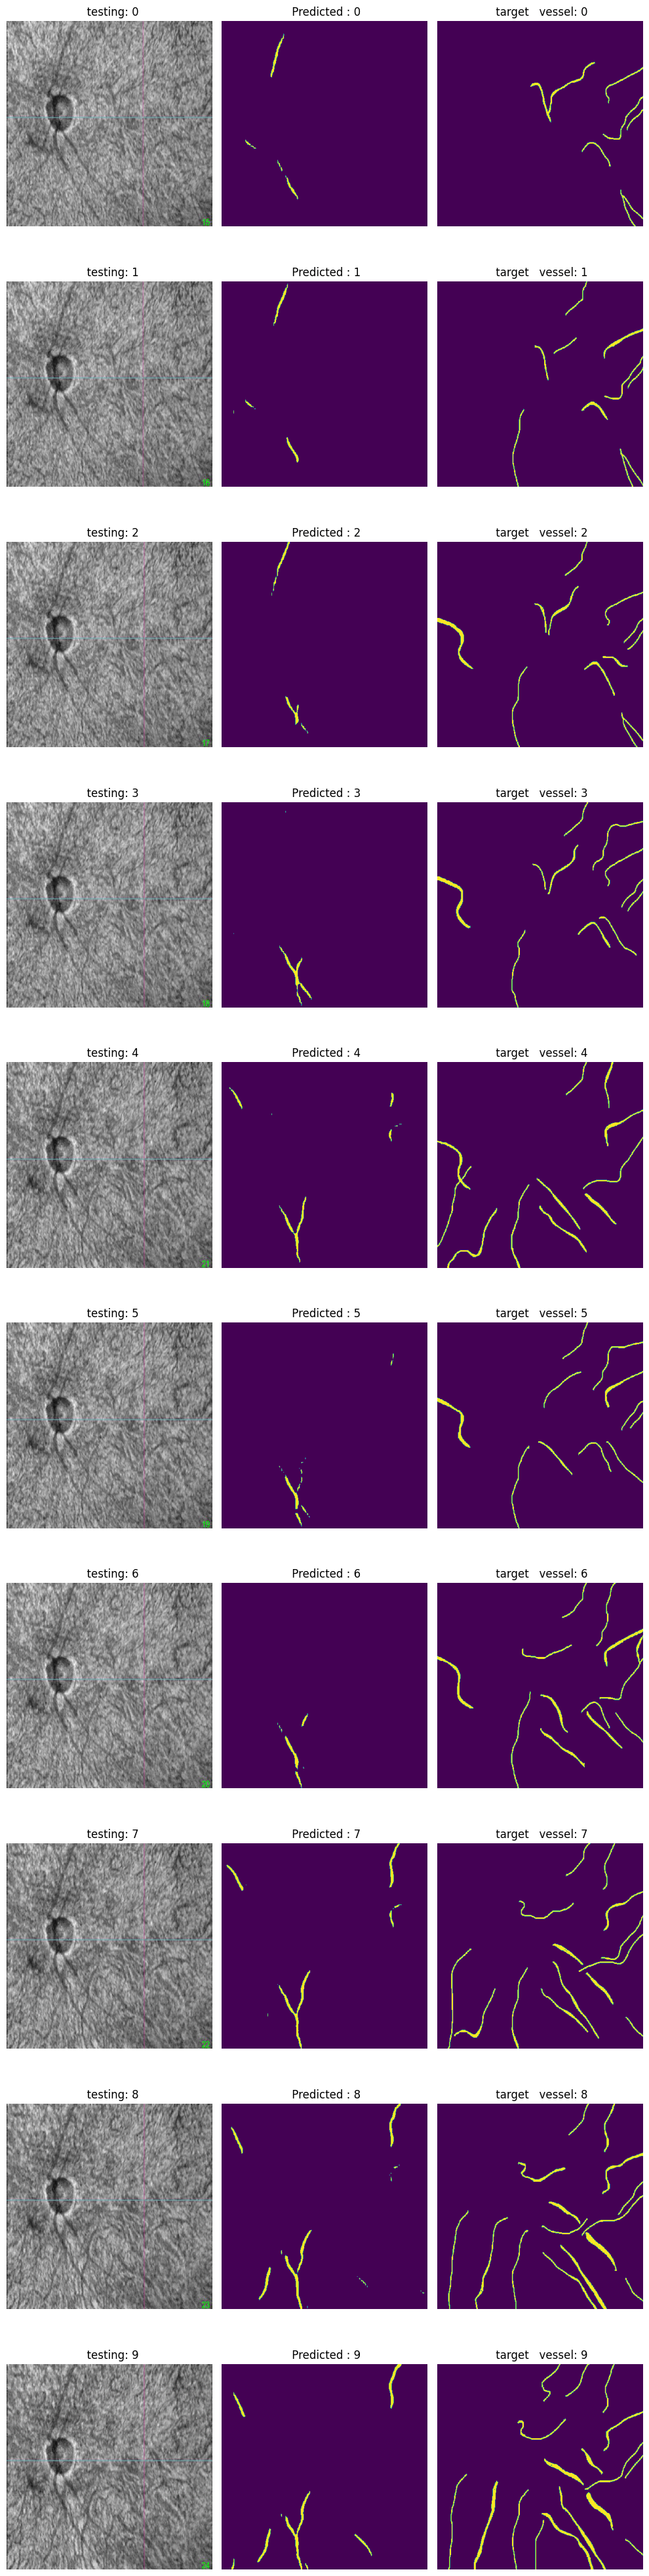

In [31]:
fig, axes = plt.subplots(10, 3, figsize = (10,40))
[c_ax.axis('off') for c_ax in axes.flatten()]

for idx, (img_ax, target_ax , mask_ax ) in zip(range(10), axes):
    
# inputs[:10] , preds[:10], targets[:10], urls_list[:10]) :
    
    image = inputs[idx].astype(int).transpose(1, 2, 0) # astype(int)
    img_target = preds[idx].transpose(1, 2, 0) 
    img_mask = labels[idx].transpose(1, 2, 0)  
 
    img_ax.imshow(np.clip(image, 0, 255))

    target_ax.imshow(img_target )
    mask_ax.imshow(img_mask)

    img_ax.set_title(f'  testing: {idx}')
    target_ax.set_title(f' Predicted : {idx}')
    
    mask_ax.set_title(f' target   vessel: {idx}')
plt.tight_layout()
plt.show()